<a href="https://colab.research.google.com/github/minshyee/RecoSyS/blob/main/Collaborative_Filtering_RecoSys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# set enviroment
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

# Collaborative Filtering RecoSys

전제 : 어떤 아이템에 대해 비슷한 취향을 가진 사람들은 다른 아이템 또한 비슷한 취향을 가질것이다.

가정 : 추천 대상과 유사한(취향이 비슷한) 집단이 있을 것이다.
  - 다른 대상과 유사성을 계산
  - 유사성이 높은 대상들을 취향이 비슷한 집단으로 판단


### 유사도지표
- 상관계수 : 이 지표 하나만을 가지고 판단할 수 없음

$$
-1 \le r = \frac{\sum(x_i - \bar{x})(y_i - \bar{y})}
{\sqrt{{\sum(x_i - \bar{x})^2\times\sum(y_i - \bar{y})^2}}} \le 1
$$
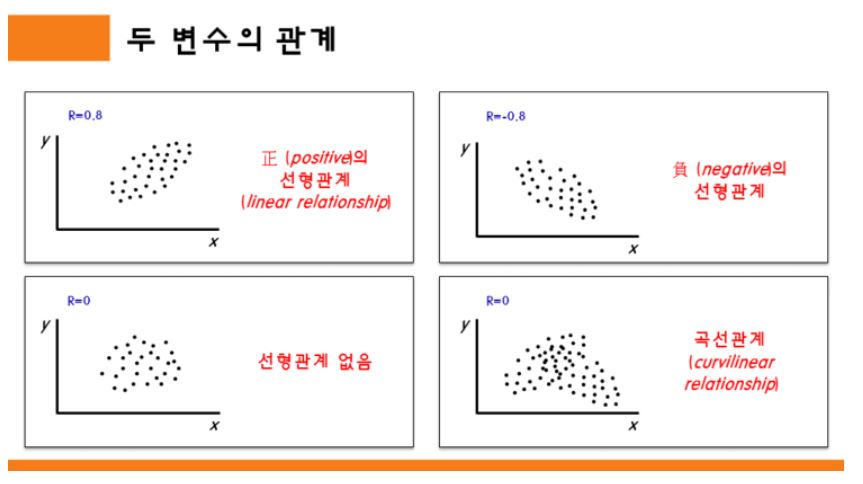
- 코사인 유사도 : 협업 필터링 알고리즘에서 널리 쓰임(주로 연속값)
  - 각 아이템 = 하나의 차원, 사용자의 평가값 = 좌표값이라고 설정
  - 두 사용자의 평가값이 유사하다면,
  𝛳는 작아지고, ${cos𝛳}$의 값은 커진다

  
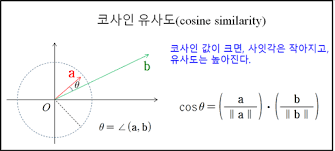



$$
-1 \le similarity = cos θ =  \frac{A \bullet B}{\lVert A \rVert \lVert B \rVert} 
= \frac{\sum{A_iB_i}}{\sqrt{\sum{A_i^2}}\sqrt{\sum{B_i^2}}}\ \le 1
$$
- 데이터가 연속값이 아니라 이진값이라면, 타니모토 계수(tanimoto coefficient) 사용을 권장한다.
- 자카드 계수의 변형 형태 
  - 자타드 계수는 합집합 분의 교집합

$$
Tanimoto\ coef = \frac{N_{a\cap b}}{N_a + N_b - N_{a\cap b}}
$$
${N_a}$는 a가 선호하는 아이템의 개수
```python3
def tanimoto(a,b):
  c=[v for v in a if v in b]
  return float(len(c))/len(a)+len(b)-len(c)
```



### 기본 CF 알고리즘
<center>

모든 사용자 간 평가의 유사도 계산 </br>

🔽 </br>

추천 대상과 다른 사용자간 유사도 추출 </br>

🔽 </br>

추천 대상이 평가하지 않은 아이템에 대한 예상 평가값 계산 </br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;* 예상 평가값 = 다른 사용자 평가 x 다른 사용자 유사도 </br>


🔽 </br>
아이템 중에서 예상 평가값 가장 높은 N개 추천
</center>  

In [27]:
# 데이터 불러오기
# user 
base_src = 'drive/MyDrive/Recosys/Data'
u_user_src = os.path.join(base_src, 'u.user')
u_cols = ['user_id', 'age', 'sex', 'occupation','zip_code']
users = pd.read_csv(u_user_src,
                    sep='|',
                    names=u_cols,
                    encoding='latin-1')
users = users.set_index('user_id')
# item
u_item_src = os.path.join(base_src, 'u.item')
item_cols = ['movie_id','title','release date','video release date',' IMDB URL','unknown', 'Action', 'Adventure', 'Animation', 'Children\'s','Comedy','Crime','Documentary','Drama', 'Fantasy', 'Film-Noir', ' Horror', 'Musical', 'Mysterty', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv(u_item_src,
                    sep='|',
                    names=item_cols, 
                    encoding='latin-1')
movies = items.set_index('movie_id')
# data
u_data_src = os.path.join(base_src, 'u.data')
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(u_data_src,
                    sep='\t',
                    names=r_cols,
                    encoding='latin-1')

In [28]:
# 정확도 측정 RMSE

def RMSE(y_true, y_pred):
  return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

# 모델별 RMSE 구하는 함수
def score(model):
  # 테스트 데이터의 user_id와 movie_id 간 pair를 튜블형 원소로 만들어줌 - > list
  id_pairs = zip(x_test['user_id'], x_test['movie_id']) # user_id - movie_id 
  # 모든 사용자-영화 짝에 대해 주어진 예측 모델을 이용하여 예측값을 계산 -> list  
  y_pred = np.array([model(user,movie) for (user, movie) in id_pairs])
  y_true = np.array(x_test['rating']) # 실제 평점값 (성능 비교를 위한 정답 값)
  return RMSE(y_true, y_pred) 

In [29]:
# create dataset
x = ratings.copy()
y = ratings['user_id']

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,stratify=y)

ratings_matrix = x_train.pivot(index='user_id',columns='movie_id',values='rating')

In [30]:
# 코사인 유사도 계산
matrix_dummy = ratings_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy) # user id 기반 행렬
user_similarity = pd.DataFrame(user_similarity, index=ratings_matrix.index, columns=ratings_matrix.index)

In [31]:
## 주어진 영화 movie_id 가중 평균 rating을 계산하는 함수
def CF_simple(user_id, movie_id):
  if movie_id in ratings_matrix.columns: # 원하는 영화 평점이 있다면
    sim_scores = user_similarity[user_id].copy() #user_id의 유사도 복사 -> user 수 만큼의 정보 존재
    movie_ratings = ratings_matrix[movie_id].copy() # 영화 평점 복사 -> 영화id에 해당하는 영화에 대해 평점을 남긴 유저(index)들 정보가 있는 열 전체
    none_rating_idx = movie_ratings[movie_ratings.isnull()].index # 평점이 없는 유저(index) 저장
    movie_ratings = movie_ratings.dropna() # 영화 평점 없는 행 삭제
    sim_scores = sim_scores.drop(none_rating_idx) # 평점 없는 유저(index) 유사도에서 행 삭제
    mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum() # 가중 평균 rating 계산
  else:
    mean_rating = 3.0
  return mean_rating

In [32]:
## 정확도 계산
score(CF_simple)

1.014995049306688

유사도가 높은 사용자에게 가중치를 더 주어 평균을 계산하면, 좀 더 정확한 예측 결과를 얻을 수 있다.

# Reference
- https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=y4769&logNo=220227007641
- http://matrix.skku.ac.kr/math4AI-tools/cosine_similarity/